In [1]:
import sys
import numpy
import pickle
import matplotlib.pyplot as plt, pandas as pd, matplotlib as mpl, random
def utkarshGrid(): plt.minorticks_on() ; plt.grid(color='grey',which='minor',linestyle=":",linewidth='0.1',) ; plt.grid(color='black',which='major',linestyle=":",linewidth='0.1',); return None
def utkarshGridAX(ax): ax.minorticks_on() ; ax.grid(color='grey',which='minor',linestyle=":",linewidth='0.1',) ; ax.grid(color='black',which='major',linestyle=":",linewidth='0.1',); return None
mpl.rcParams['legend.frameon'], mpl.rcParams['figure.autolayout'] = False, True,
colour = ["dodgerblue", "goldenrod", "crimson", "teal", "yellowgreen", "grey"]
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": ["Palatino"],})
def utkarshWrapper(): plt.legend();plt.utkarshGrid() ;plt.gca().tick_params(direction='in', which='both', right=True, top=True); plt.tight_layout(); return None
def utkarshWrapperAX(ax): utkarshGridAX(ax); ax.tick_params(direction='in', which='both', right=True, top=True); return None; 
plt.utkarshGrid = utkarshGrid; plt.utkarshWrapper = utkarshWrapper
def colour_sample(n = 2, col = colour, seed = 7236): random.seed(seed) ; return random.sample(colour, n)
plt.rcParams["image.cmap"] = "Set2" # I recommend, Set2, Dark2
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colour) # Use your own OR plt.cm.Set2.colors

In [2]:
%reload_ext autoreload
%autoreload 2
from run_inference import *
from postprocessing_functions import *

/Users/utkarsh/GitHub/P_NS/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
mcmc = None
path = f"results/prior"
mcmc = pickle_read(path)
prior_samples = infer_samples(mcmc)

In [4]:
mcmc = None
path = f"results/posterior"
mcmc = pickle_read(path)
posterior_samples = infer_samples(mcmc)
mcmc.print_summary()


                         mean       std    median      5.0%     95.0%     n_eff     r_hat
               A[0]      0.03      0.57      0.04     -0.83      0.95   3663.87      1.00
         alpha_1[0]     -1.43      1.55     -1.26     -4.28      0.66   1523.85      1.00
         alpha_2[0]     -0.16      0.46     -0.17     -0.92      0.56   1550.90      1.00
          beta_1[0]      1.13      0.49      1.09      0.33      1.92   2861.86      1.00
          beta_2[0]      2.28      0.75      2.22      1.09      3.51   2660.43      1.00
        eta_high[0]     25.06     14.23     25.17      0.55     44.94   5645.39      1.00
         eta_low[0]     24.95     14.57     24.72      2.45     47.50   5315.09      1.00
         eta_max[0]      4.50      2.71      4.25      0.00      8.55   3169.20      1.00
         eta_min[0]     30.57     11.33     30.99     12.21     47.43   4658.30      1.00
      gamma_high[0]      6.00      1.19      5.99      4.26      7.88   3962.23      1.00
       ga

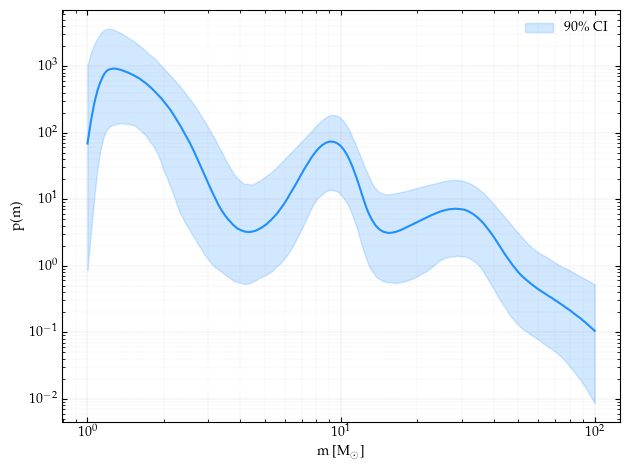

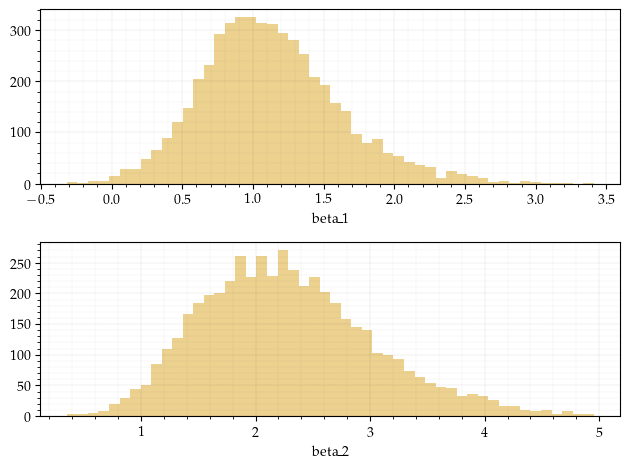

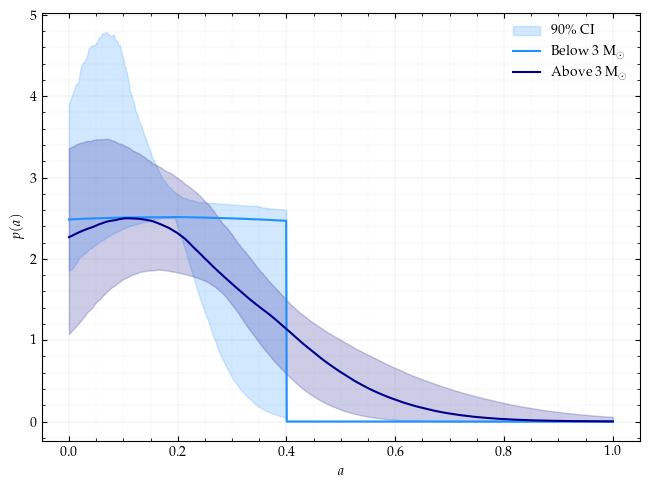

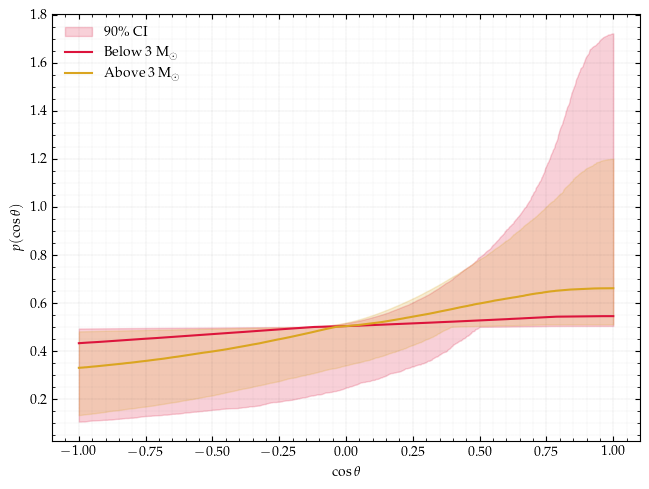

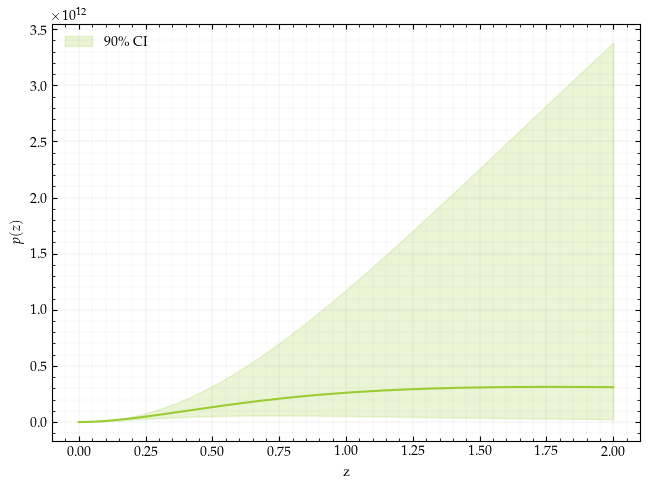

In [5]:
from config.mass1d_func import pdb_with_NG
from config.spin_func import prob_chi, prob_costilt
from config.distance_func import powerlaw_redshift

plot_p_m(posterior_samples, function=pdb_with_NG)
plot_p_pairing(posterior_samples)
plot_p_chi(posterior_samples, function=prob_chi)
plot_p_costilt(posterior_samples, function=prob_costilt)
plot_p_z(posterior_samples, function=powerlaw_redshift)
plt.show()

In [6]:
# import arviz as az
# data = az.from_numpyro(mcmc)
# var_names_lst = get_non_deterministic_params(mcmc)
#
# if len(var_names_lst) >= 20:
#     cut1 = var_names_lst[:20]
#     cut2 = var_names_lst[20:]
#
#     assert len(cut1) + len(cut2) == len(var_names_lst)
#
#     az.plot_trace(data, var_names=cut1, compact=True)
#     plt.savefig("results/trace1.png")
#     az.plot_trace(data, var_names=cut2, compact=True)
#     plt.savefig("results/trace2.png")
# else:
#     az.plot_trace(data, var_names=var_names_lst, compact=True)
#     plt.savefig("results/trace.png")

In [7]:
from model_vector import model_vector
postprocessed_posterior_samples = add_postprocessing_effects(posterior_samples, model_vector)

with open("results/postprocessed_samples", "wb") as f:
    pickle.dump(postprocessed_posterior_samples, f)

Not in COURSE GRAIN: 66


100%|██████████| 66/66 [00:06<00:00, 10.17it/s]


In COURSE GRAIN: 0


100%|██████████| 5000/5000 [12:20<00:00,  6.75it/s]


100%|██████████| 66/66 [00:10<00:00,  6.47it/s]
/Users/utkarsh/GitHub/P_NS/sampler/runs/pdbNG_betaSplit_brokenG_1_full/postprocessing_functions.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  def utkarshWrapper(): plt.legend();plt.utkarshGrid() ;plt.gca().tick_params(direction='in', which='both', right=True, top=True); plt.tight_layout(); return None


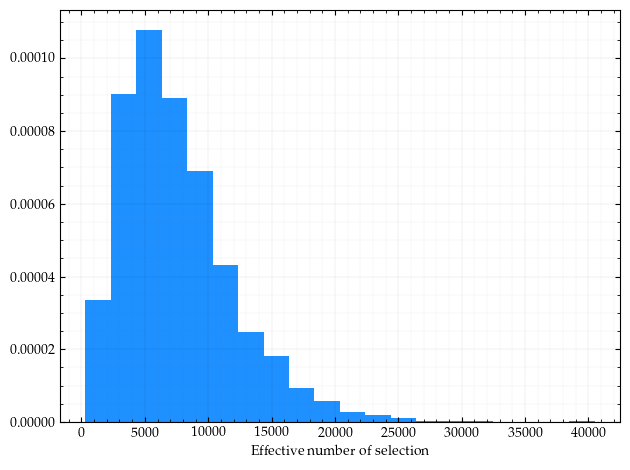

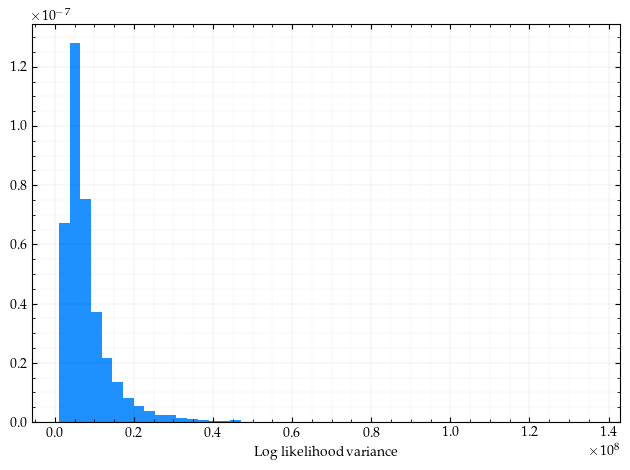

In [8]:
import os
if not os.path.exists("results/monte_carlo_uncertainty"):
    os.makedirs("results/monte_carlo_uncertainty")

config = configparser.ConfigParser()
config.read('config/config.ini')
event_folder_name = config["DIRECTORIES"]["event_folder_name"]
event_file_name = config["DIRECTORIES"]["event_file_name"]
translate_dir = "../../"
events = numpy.loadtxt(translate_dir+event_folder_name+event_file_name, dtype=str)

for event_i in tqdm(range(len(postprocessed_posterior_samples["neff_events"].T))):
    plt.figure()
    plt.hist(postprocessed_posterior_samples["neff_events"].T[event_i], label = events[event_i][:8], bins = 50, density=True)
    plt.xlabel(f"Effective number of single events evidence")
    plt.utkarshWrapper()
    plt.savefig(f"results/monte_carlo_uncertainty/{events[event_i][:14]}.png")
    plt.close()

plt.figure()
plt.hist(postprocessed_posterior_samples["neff_selection"], bins=20, density=True)
plt.xlabel("Effective number of selection")
plt.utkarshWrapper()
plt.savefig("results/monte_carlo_uncertainty/neff_selection.png")

plt.figure()
plt.hist(postprocessed_posterior_samples["loglike_var"], bins=50, density=True)
plt.xlabel("Log likelihood variance")
plt.utkarshWrapper()
plt.savefig("results/monte_carlo_uncertainty/loglike_var.png")